In [18]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Modelos de Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Selección y validación de modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV, StratifiedKFold

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Métricas de evaluación
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

#Se importan las librerias necesarias para el uso de pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid

# Se define el dispositivo a utilizar
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Número de GPU disponibles:", torch.cuda.device_count())
    print("Nombre de la GPU 0:", torch.cuda.get_device_name(0))
    print("Dispositivo actual:", torch.cuda.current_device())


2.3.0
CUDA disponible: True
Número de GPU disponibles: 1
Nombre de la GPU 0: NVIDIA GeForce RTX 3090
Dispositivo actual: 0


In [19]:
# Se define la funcion para graficar la perdida por epoca
def graficar_progreso(losses, inicio_folds, dataset_name, grado=3):
    plt.figure(figsize=(20, 10))
    # Gráfico original
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='blue', label='Pérdida Real')

     # Marcar y anotar el inicio de cada fold
    for i, inicio in enumerate(inicio_folds):
        plt.axvline(x=inicio, color='black', linestyle='--', lw=1)
        plt.text(inicio, max(losses)*0.95, f'Inicio Fold {i+1}', rotation=90, color='black', fontsize=12, fontweight='bold')

    # Ajustando la curva de tendencia
    z = np.polyfit(range(1, len(losses) + 1), losses, grado)  # Ajuste polinomial
    p = np.poly1d(z)  # Creación de un polinomio
    plt.plot(range(1, len(losses) + 1), p(range(1, len(losses) + 1)), "r--", label='Curva de Tendencia')  # Curva de tendencia en rojo

    # Configuración del gráfico
    plt.title(f'Pérdida por Época a través de los Folds, Dataset: {dataset_name}')
    plt.xlabel('Época Total')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
def evaluar_modelo_pytorch(model, X_train_tensor, y_train, X_test_tensor, y_test, dataset_name):
    # Evaluación con datos de entrenamiento
    y_pred = model(X_train_tensor).detach().cpu().numpy()
    y_pred_bin = (y_pred > 0.5).astype(int)

    # Cálculo de métricas para datos de entrenamiento
    accuracy = accuracy_score(y_train, y_pred_bin)
    precision = precision_score(y_train, y_pred_bin)
    recall = recall_score(y_train, y_pred_bin)
    f1 = f1_score(y_train, y_pred_bin)

    # Visualización de métricas y gráficos para datos de entrenamiento
    print('\033[1m' + '.' * len("Resultados datos de entrenamiento:") + '\n' + "Resultados datos de entrenamiento:" + '\033[0m')
    print(f"Accuracy (Datos de Train): {accuracy}")
    print(f"Precision (Datos de Train): {precision}")
    print(f"Recall (Datos de Train): {recall}")
    print(f"F1 Score (Datos de Train): {f1}")

    # Gráficos para datos de entrenamiento
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Train para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix = confusion_matrix(y_train, y_pred_bin)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Train)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix)

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Train)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Evaluación con datos de prueba
    y_pred_test = model(X_test_tensor).detach().cpu().numpy()
    y_pred_test_bin = (y_pred_test > 0.5).astype(int)

    # Cálculo de métricas para datos de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test_bin)
    precision_test = precision_score(y_test, y_pred_test_bin)
    recall_test = recall_score(y_test, y_pred_test_bin)
    f1_test = f1_score(y_test, y_pred_test_bin)

    # Visualización de métricas y gráficos para datos de prueba
    print('\033[1m' + '.' * len("Resultados datos de test:") + '\n' + "Resultados datos de test:" + '\033[0m')
    print(f"Accuracy (Datos de Test): {accuracy_test}")
    print(f"Precision (Datos de Test): {precision_test}")
    print(f"Recall (Datos de Test): {recall_test}")
    print(f"F1 Score (Datos de Test): {f1_test}")

    # Gráficos para datos de prueba
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'Resultados de Test para el Dataset: - {dataset_name}', fontsize=16, fontweight='bold', y=1.05)
    conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                xticklabels=['Asiste', 'No-show'], yticklabels=['Asiste', 'No-show'])
    axes[0].set_title('Matriz de Confusión (Datos de Test)')
    axes[0].set_xlabel('Predicho')
    axes[0].set_ylabel('Real')
    print(conf_matrix_test)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Curva ROC (Datos de Test)')
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [21]:
# Se define el dispositivo a utilizar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Se define la función para ejecutar el modelo en PyTorch
def execute_model_pytorch(X_train, y_train, X_test, y_test, device, dataset_name):
    class NeuralNet(nn.Module):
        def __init__(self, input_size):
            super(NeuralNet, self).__init__()
            self.layer1 = nn.Linear(input_size, 64)
            self.bn1 = nn.BatchNorm1d(64)
            self.relu1 = nn.ReLU()

            self.layer2 = nn.Linear(64, 32)
            self.bn2 = nn.BatchNorm1d(32)
            self.relu2 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.5)

            self.output_layer = nn.Linear(32, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.bn1(self.layer1(x))
            out = self.relu1(out)

            out = self.bn2(self.layer2(out))
            out = self.relu2(out)
            out = self.dropout1(out)

            out = self.output_layer(out)
            out = self.sigmoid(out)
            return out

    model = NeuralNet(X_train.shape[1]).to(device)

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    model_filename = os.path.join(model_dir, f'modelo_pytorch_{dataset_name}.pth')

    if os.path.exists(model_filename):
        model.load_state_dict(torch.load(model_filename))
        print("Modelo cargado exitosamente.")

        X_test_tensor = torch.tensor(X_test).float().to(device)
        X_train_fold_tensor = torch.tensor(X_train).float().to(device)
        y_train_fold = y_train
        evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)
        return

    skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    num_epochs = 100
    patience = 10  # Número de épocas a esperar antes de detener el entrenamiento si no hay mejora
    fold_results = []
    losses = []
    inicio_folds = [1]
    epoca_actual = 0

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    best_global_val_loss = float('inf')
    best_model_state = None

    for fold, (train_index, test_index) in enumerate(skfolds.split(X_train, y_train)):
        print(f'Comenzando el fold {fold+1}')

        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        X_valid_fold = X_train[test_index]
        y_valid_fold = y_train[test_index]

        X_train_fold_tensor = torch.tensor(X_train_fold).float().to(device)
        y_train_fold_tensor = torch.tensor(y_train_fold.to_numpy()[:, None]).float().to(device)
        X_valid_fold_tensor = torch.tensor(X_valid_fold).float().to(device)
        y_valid_fold_tensor = torch.tensor(y_valid_fold.to_numpy()[:, None]).float().to(device)

        train_loader = DataLoader(TensorDataset(X_train_fold_tensor, y_train_fold_tensor), batch_size=64, shuffle=True)
        valid_loader = DataLoader(TensorDataset(X_valid_fold_tensor, y_valid_fold_tensor), batch_size=64)

        epoch_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(num_epochs):
            model.train()
            train_losses = []
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for inputs, targets in valid_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_losses.append(loss.item())

            epoch_train_loss = torch.tensor(train_losses).mean().item()
            epoch_val_loss = torch.tensor(val_losses).mean().item()
            epoch_losses.append((epoch_train_loss, epoch_val_loss))
            losses.append(epoch_val_loss)
            print(f'Fold {fold+1}, Epoch {epoch+1}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

            # Step the scheduler
            scheduler.step(epoch_val_loss)

            # Early Stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                patience_counter = 0
                # Guardar el mejor modelo del fold actual
                if epoch_val_loss < best_global_val_loss:
                    best_global_val_loss = epoch_val_loss
                    best_model_state = model.state_dict()
            else:
                patience_counter += 1

            if patience_counter >= patience and epoch >= (num_epochs // 2):  # Modificar la condición de stop
                print(f'Early stopping en la época {epoch+1}')
                break

        fold_results.append({
            'fold': fold+1,
            'epoch_losses': epoch_losses,
        })
        if fold < skfolds.n_splits - 1:
            epoca_actual += num_epochs
            inicio_folds.append(epoca_actual + 1)

    # Guardar el mejor modelo global
    torch.save(best_model_state, model_filename)
    print(f"Mejor modelo guardado en {model_filename}")

    graficar_progreso(losses, inicio_folds, dataset_name, grado=3)

    X_test_tensor = torch.tensor(X_test).float().to(device)

    X_train_fold_tensor = torch.tensor(X_train).float().to(device)
    y_train_fold = y_train

    evaluar_modelo_pytorch(model, X_train_fold_tensor, y_train_fold, X_test_tensor, y_test, dataset_name)



Ejecutando modelo para el dataset: P1-ALL-ADASYN

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6841, Val Loss: 0.6590
Fold 1, Epoch 2, Train Loss: 0.6620, Val Loss: 0.6434
Fold 1, Epoch 3, Train Loss: 0.6478, Val Loss: 0.6315
Fold 1, Epoch 4, Train Loss: 0.6367, Val Loss: 0.6205
Fold 1, Epoch 5, Train Loss: 0.6290, Val Loss: 0.6133
Fold 1, Epoch 6, Train Loss: 0.6239, Val Loss: 0.6094
Fold 1, Epoch 7, Train Loss: 0.6201, Val Loss: 0.6064
Fold 1, Epoch 8, Train Loss: 0.6160, Val Loss: 0.6029
Fold 1, Epoch 9, Train Loss: 0.6138, Val Loss: 0.5991
Fold 1, Epoch 10, Train Loss: 0.6111, Val Loss: 0.5967
Fold 1, Epoch 11, Train Loss: 0.6098, Val Loss: 0.5959
Fold 1, Epoch 12, Train Loss: 0.6072, Val Loss: 0.5919
Fold 1, Epoch 13, Train Loss: 0.6063, Val Loss: 0.5939
Fold 1, Epoch 14, Train Loss: 0.6044, Val Loss: 0.5887
Fold 1, Epoch 15, Train Loss: 0.6034, Val Loss: 0.5913
Fold 1, Epoch 16, Train Loss: 0.6017, Val Loss: 0.5880
Fold 1, Epoch 17, Train Loss: 0.5998, Val Loss: 0.5841
Fo

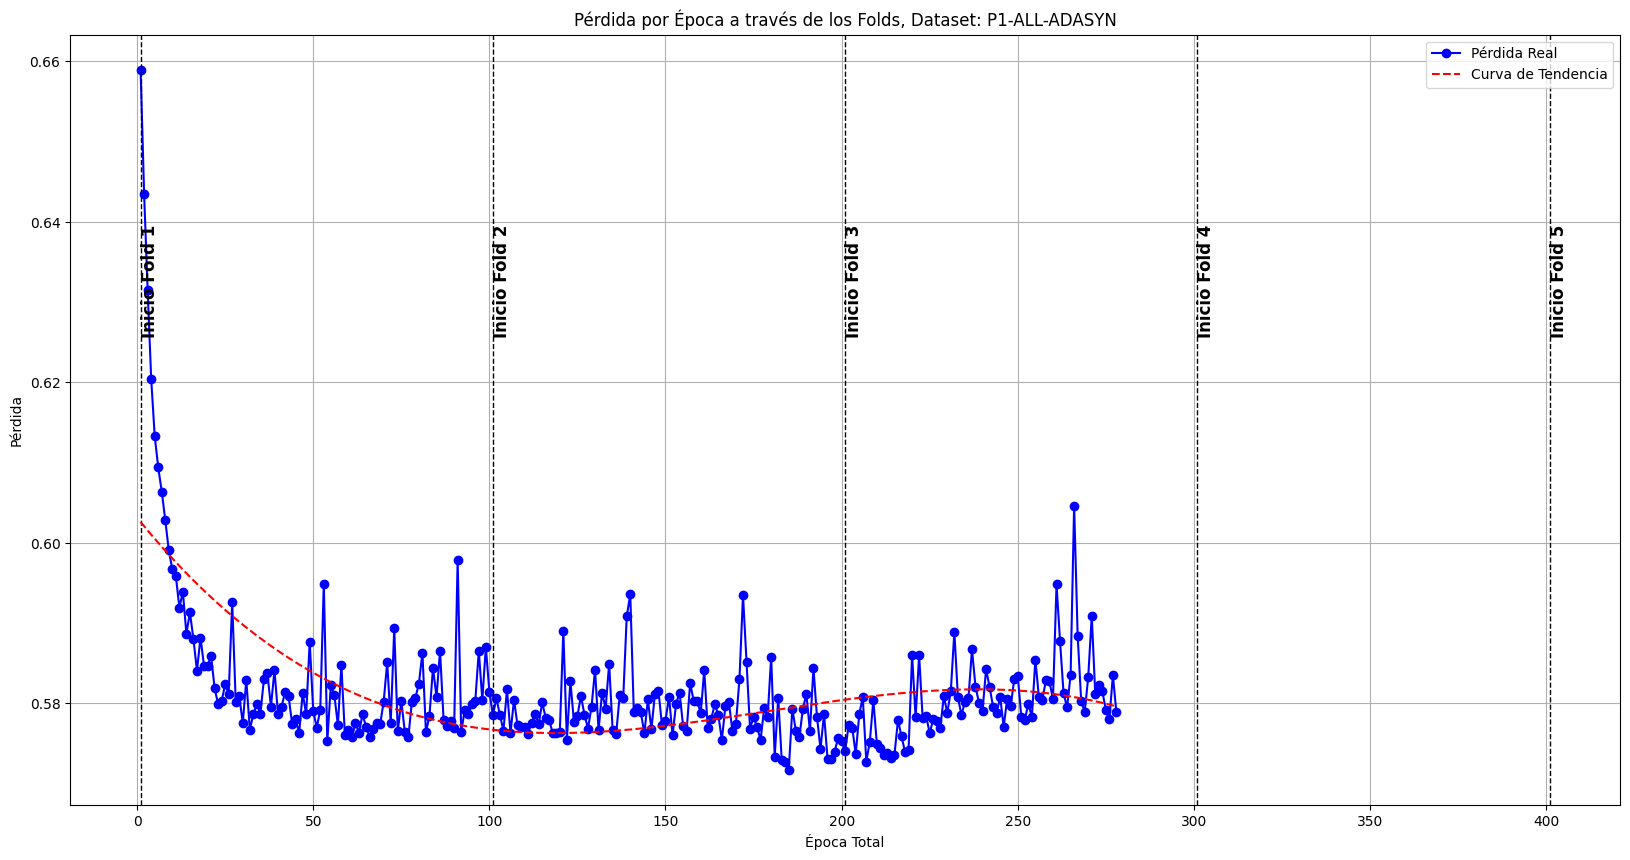

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6841979388615906
Precision (Datos de Train): 0.6292541322761639
Recall (Datos de Train): 0.8614047834403404
F1 Score (Datos de Train): 0.7272522423840313
[[36313 34228]
 [ 9347 58094]]


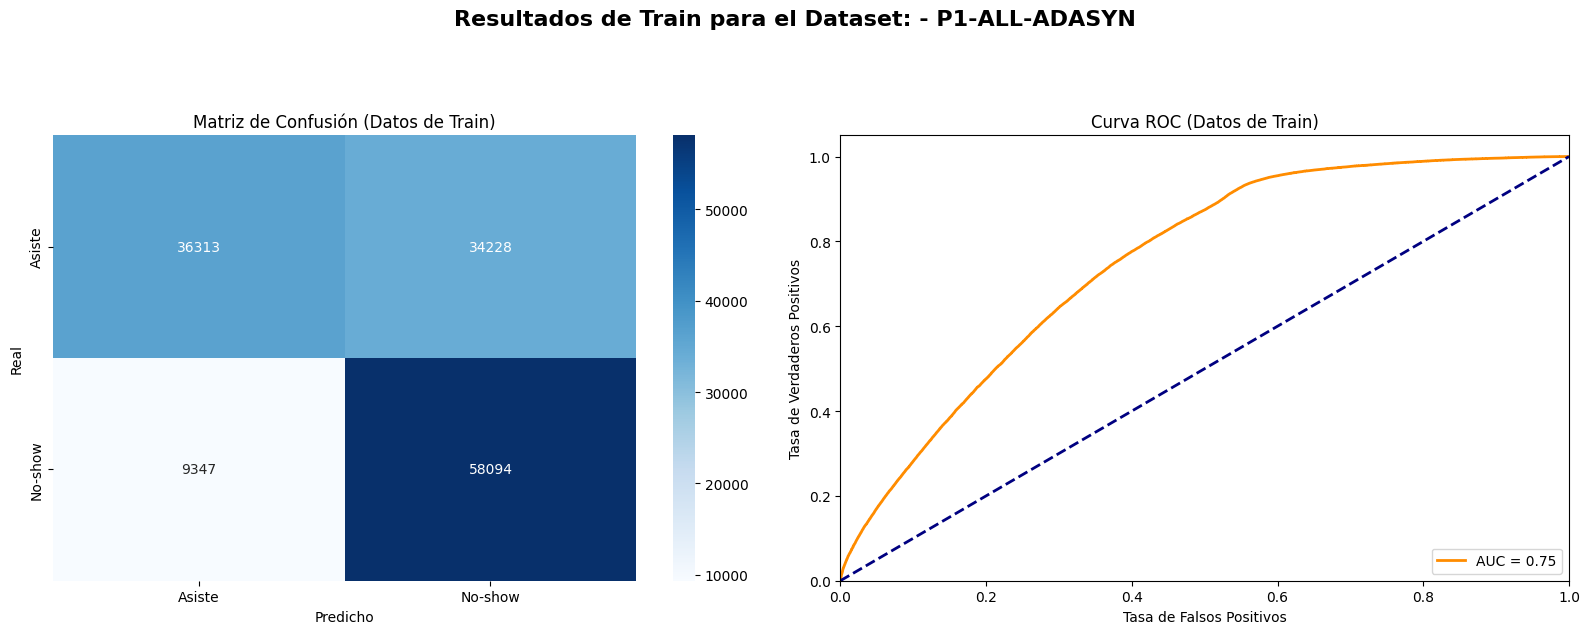

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.5878173507715979
Precision (Datos de Test): 0.3010531723606473
Recall (Datos de Test): 0.7881640887693342
F1 Score (Datos de Test): 0.4356877323420074
[[9473 8163]
 [ 945 3516]]


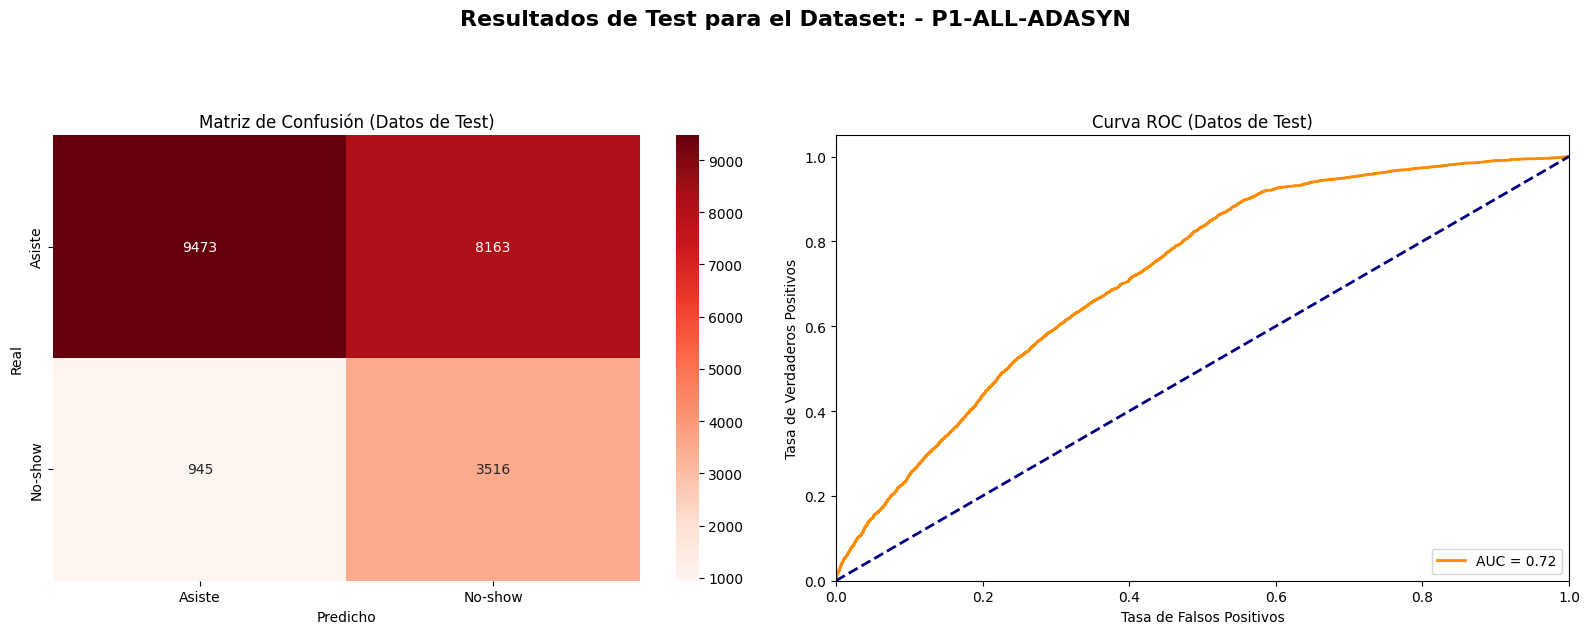


Ejecutando modelo para el dataset: P1-ALL

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6575, Val Loss: 0.6173
Fold 1, Epoch 2, Train Loss: 0.6203, Val Loss: 0.5984
Fold 1, Epoch 3, Train Loss: 0.6059, Val Loss: 0.5873
Fold 1, Epoch 4, Train Loss: 0.5974, Val Loss: 0.5806
Fold 1, Epoch 5, Train Loss: 0.5908, Val Loss: 0.5741
Fold 1, Epoch 6, Train Loss: 0.5860, Val Loss: 0.5709
Fold 1, Epoch 7, Train Loss: 0.5831, Val Loss: 0.5672
Fold 1, Epoch 8, Train Loss: 0.5800, Val Loss: 0.5667
Fold 1, Epoch 9, Train Loss: 0.5771, Val Loss: 0.5618
Fold 1, Epoch 10, Train Loss: 0.5751, Val Loss: 0.5642
Fold 1, Epoch 11, Train Loss: 0.5726, Val Loss: 0.5595
Fold 1, Epoch 12, Train Loss: 0.5721, Val Loss: 0.5576
Fold 1, Epoch 13, Train Loss: 0.5697, Val Loss: 0.5549
Fold 1, Epoch 14, Train Loss: 0.5687, Val Loss: 0.5533
Fold 1, Epoch 15, Train Loss: 0.5668, Val Loss: 0.5534
Fold 1, Epoch 16, Train Loss: 0.5661, Val Loss: 0.5514
Fold 1, Epoch 17, Train Loss: 0.5643, Val Loss: 0.5544
Fold 1, E

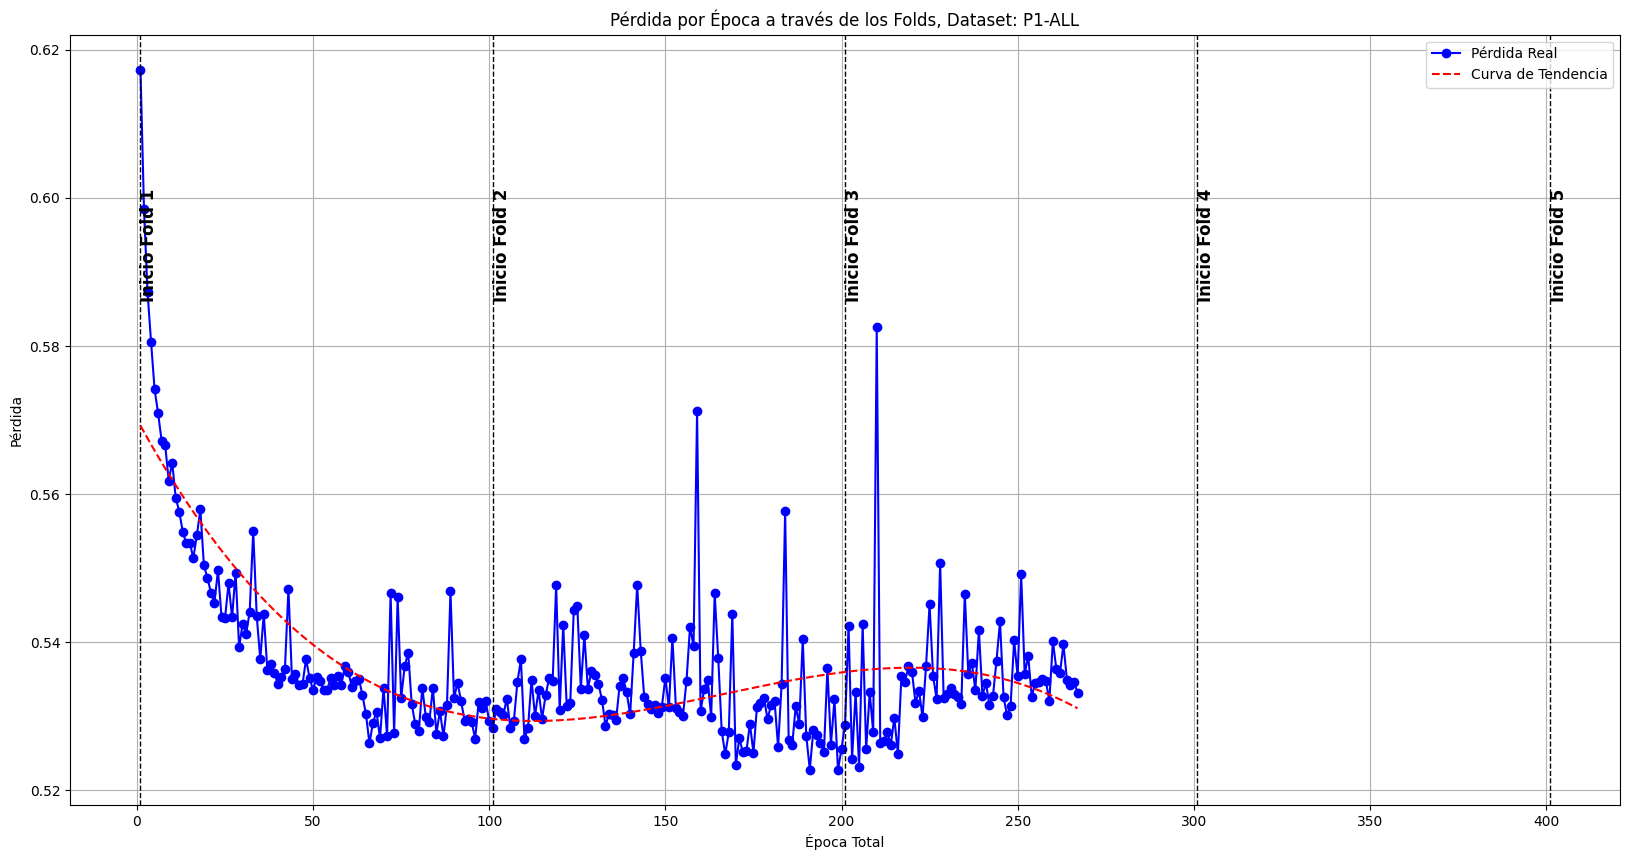

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7159147131582048
Precision (Datos de Train): 0.6491651957521919
Recall (Datos de Train): 0.7900306370391239
F1 Score (Datos de Train): 0.7127041108075481
[[46292 24249]
 [11925 44869]]


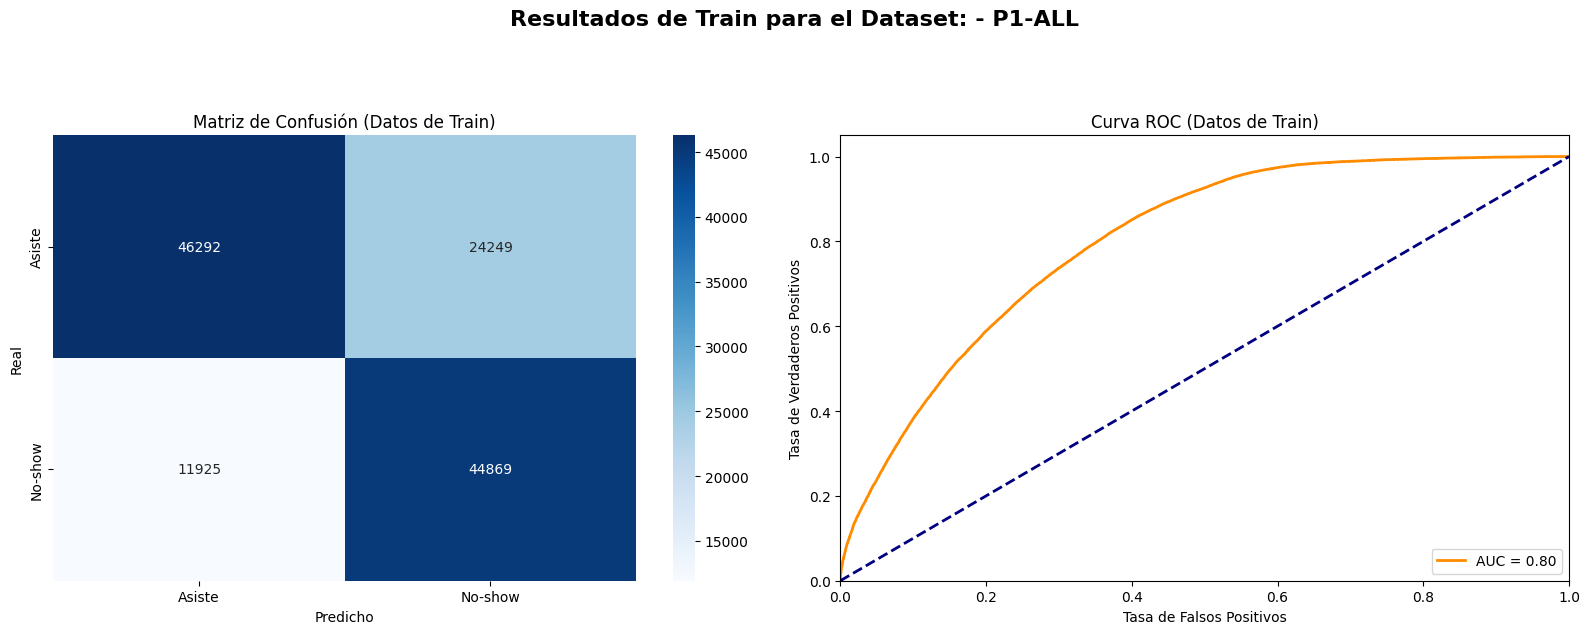

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6655202063628547
Precision (Datos de Test): 0.32366393837265284
Recall (Datos de Test): 0.602779645819323
F1 Score (Datos de Test): 0.42117628631842746
[[12017  5619]
 [ 1772  2689]]


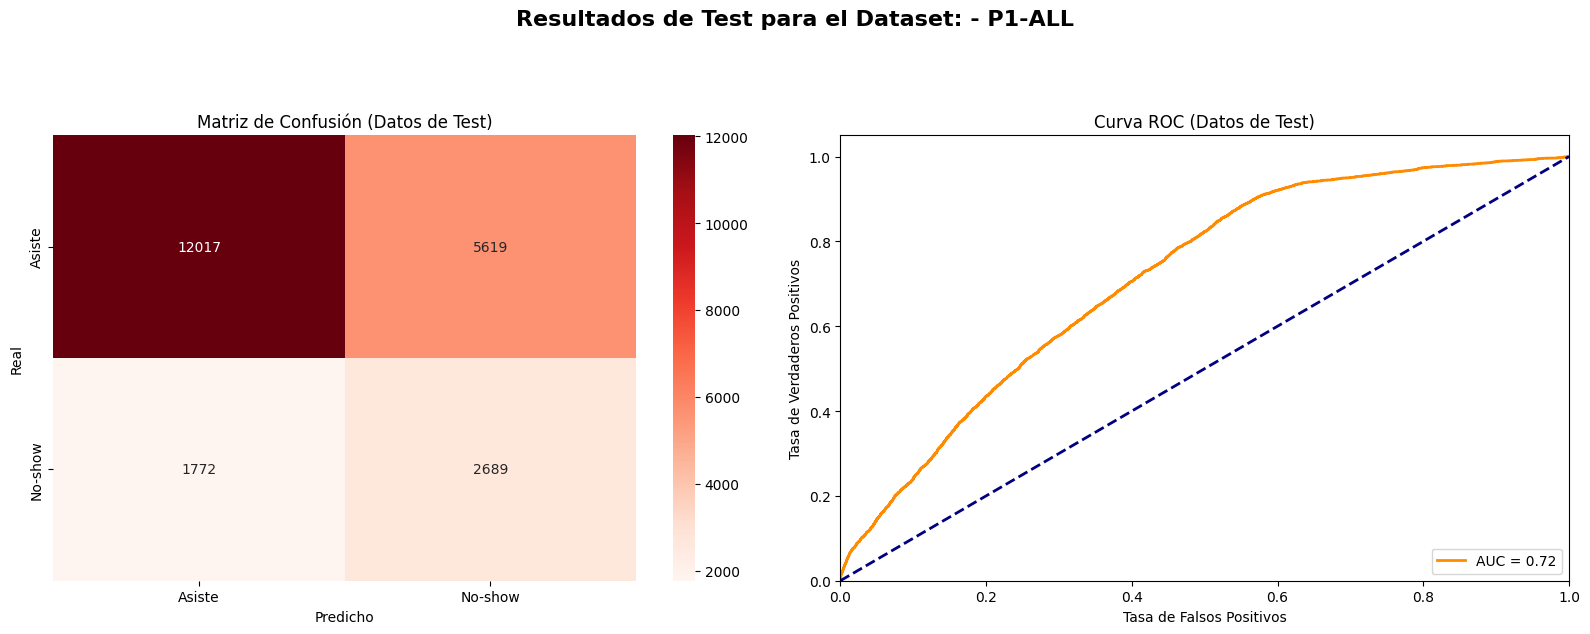


Ejecutando modelo para el dataset: P2-NOCONDITIONS

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6634, Val Loss: 0.6220
Fold 1, Epoch 2, Train Loss: 0.6231, Val Loss: 0.6007
Fold 1, Epoch 3, Train Loss: 0.6079, Val Loss: 0.5885
Fold 1, Epoch 4, Train Loss: 0.5972, Val Loss: 0.5803
Fold 1, Epoch 5, Train Loss: 0.5899, Val Loss: 0.5754
Fold 1, Epoch 6, Train Loss: 0.5848, Val Loss: 0.5716
Fold 1, Epoch 7, Train Loss: 0.5826, Val Loss: 0.5686
Fold 1, Epoch 8, Train Loss: 0.5796, Val Loss: 0.5666
Fold 1, Epoch 9, Train Loss: 0.5767, Val Loss: 0.5628
Fold 1, Epoch 10, Train Loss: 0.5752, Val Loss: 0.5615
Fold 1, Epoch 11, Train Loss: 0.5723, Val Loss: 0.5607
Fold 1, Epoch 12, Train Loss: 0.5704, Val Loss: 0.5584
Fold 1, Epoch 13, Train Loss: 0.5683, Val Loss: 0.5568
Fold 1, Epoch 14, Train Loss: 0.5671, Val Loss: 0.5555
Fold 1, Epoch 15, Train Loss: 0.5661, Val Loss: 0.5543
Fold 1, Epoch 16, Train Loss: 0.5645, Val Loss: 0.5519
Fold 1, Epoch 17, Train Loss: 0.5629, Val Loss: 0.5515


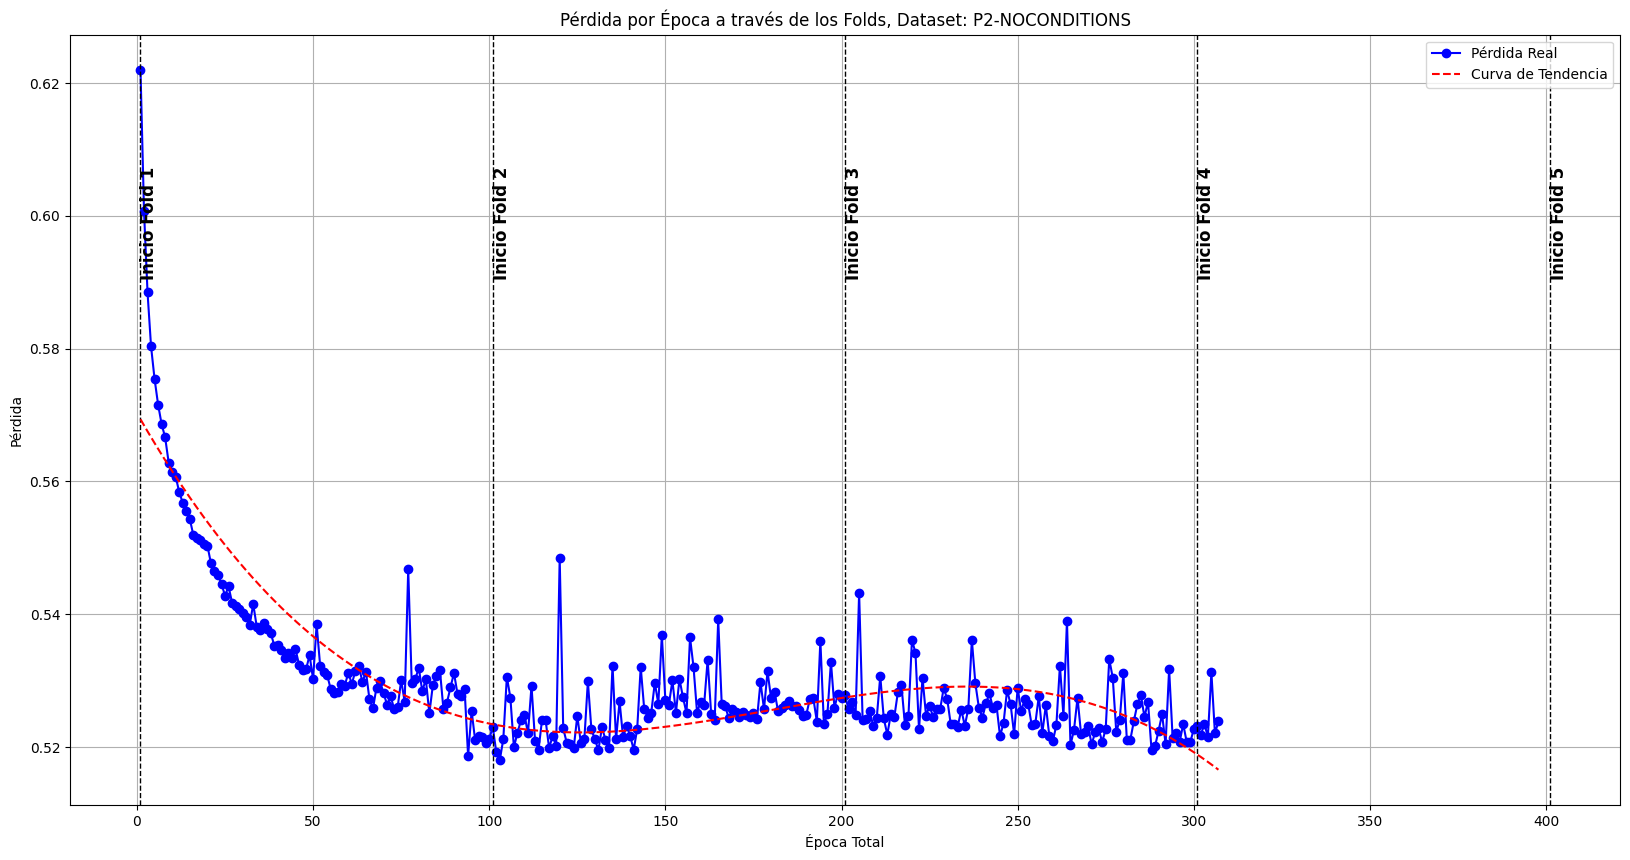

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.7227305158014018
Precision (Datos de Train): 0.6560218070395352
Recall (Datos de Train): 0.782991759481346
F1 Score (Datos de Train): 0.7139052485709336
[[35911 17288]
 [ 9138 32971]]


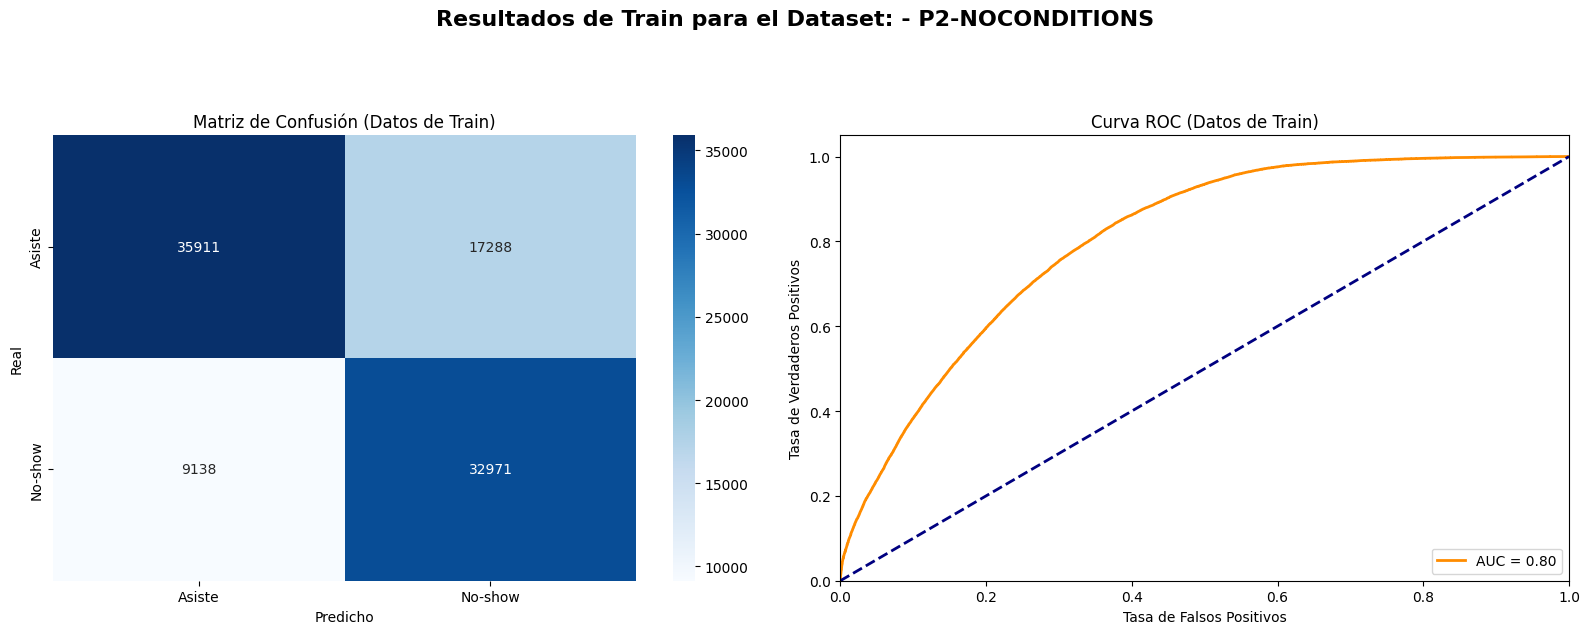

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6897556335097211
Precision (Datos de Test): 0.3484929552345283
Recall (Datos de Test): 0.5552713839158852
F1 Score (Datos de Test): 0.428227043611659
[[9647 3653]
 [1565 1954]]


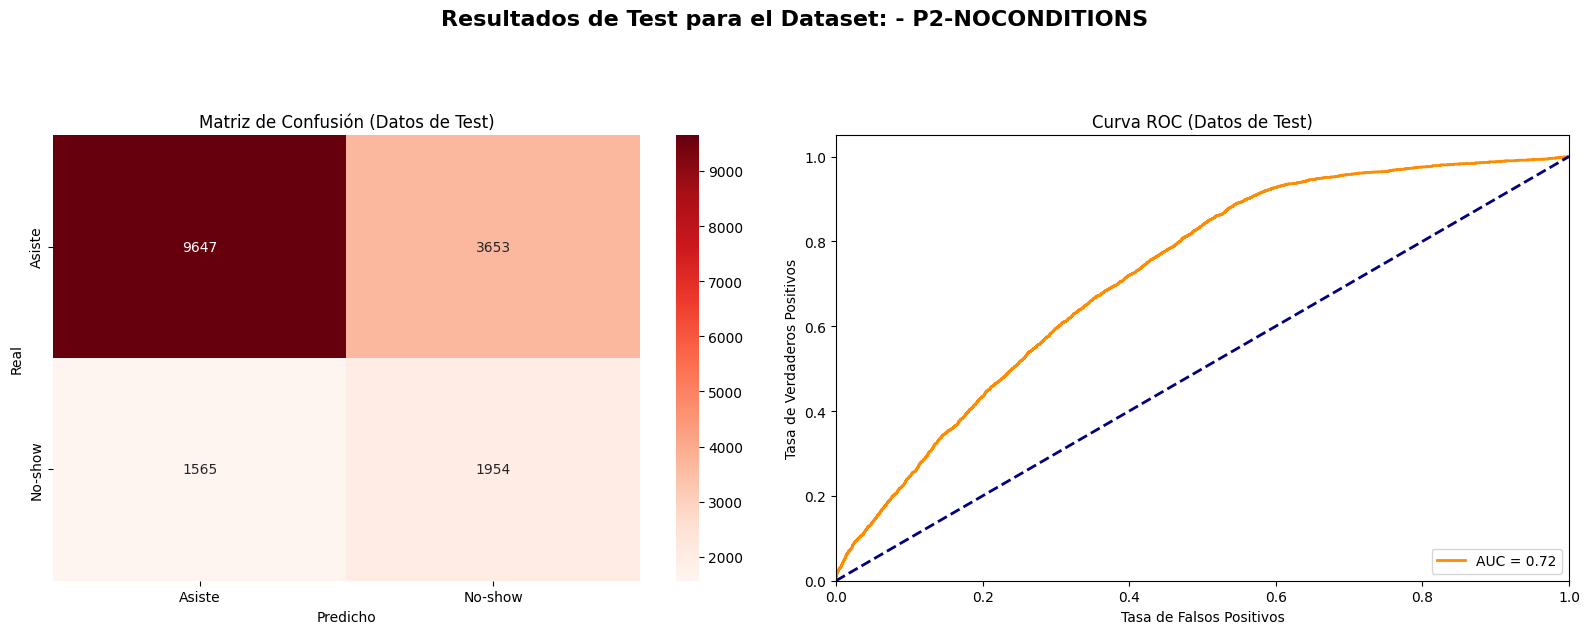


Ejecutando modelo para el dataset: P3-AGE

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6834, Val Loss: 0.6434
Fold 1, Epoch 2, Train Loss: 0.6525, Val Loss: 0.6279
Fold 1, Epoch 3, Train Loss: 0.6364, Val Loss: 0.6155
Fold 1, Epoch 4, Train Loss: 0.6243, Val Loss: 0.6058
Fold 1, Epoch 5, Train Loss: 0.6144, Val Loss: 0.5975
Fold 1, Epoch 6, Train Loss: 0.6077, Val Loss: 0.5910
Fold 1, Epoch 7, Train Loss: 0.6002, Val Loss: 0.5868
Fold 1, Epoch 8, Train Loss: 0.5954, Val Loss: 0.5812
Fold 1, Epoch 9, Train Loss: 0.5931, Val Loss: 0.5779
Fold 1, Epoch 10, Train Loss: 0.5879, Val Loss: 0.5747
Fold 1, Epoch 11, Train Loss: 0.5870, Val Loss: 0.5726
Fold 1, Epoch 12, Train Loss: 0.5840, Val Loss: 0.5706
Fold 1, Epoch 13, Train Loss: 0.5820, Val Loss: 0.5685
Fold 1, Epoch 14, Train Loss: 0.5799, Val Loss: 0.5667
Fold 1, Epoch 15, Train Loss: 0.5750, Val Loss: 0.5651
Fold 1, Epoch 16, Train Loss: 0.5765, Val Loss: 0.5635
Fold 1, Epoch 17, Train Loss: 0.5744, Val Loss: 0.5635
Fold 1, E

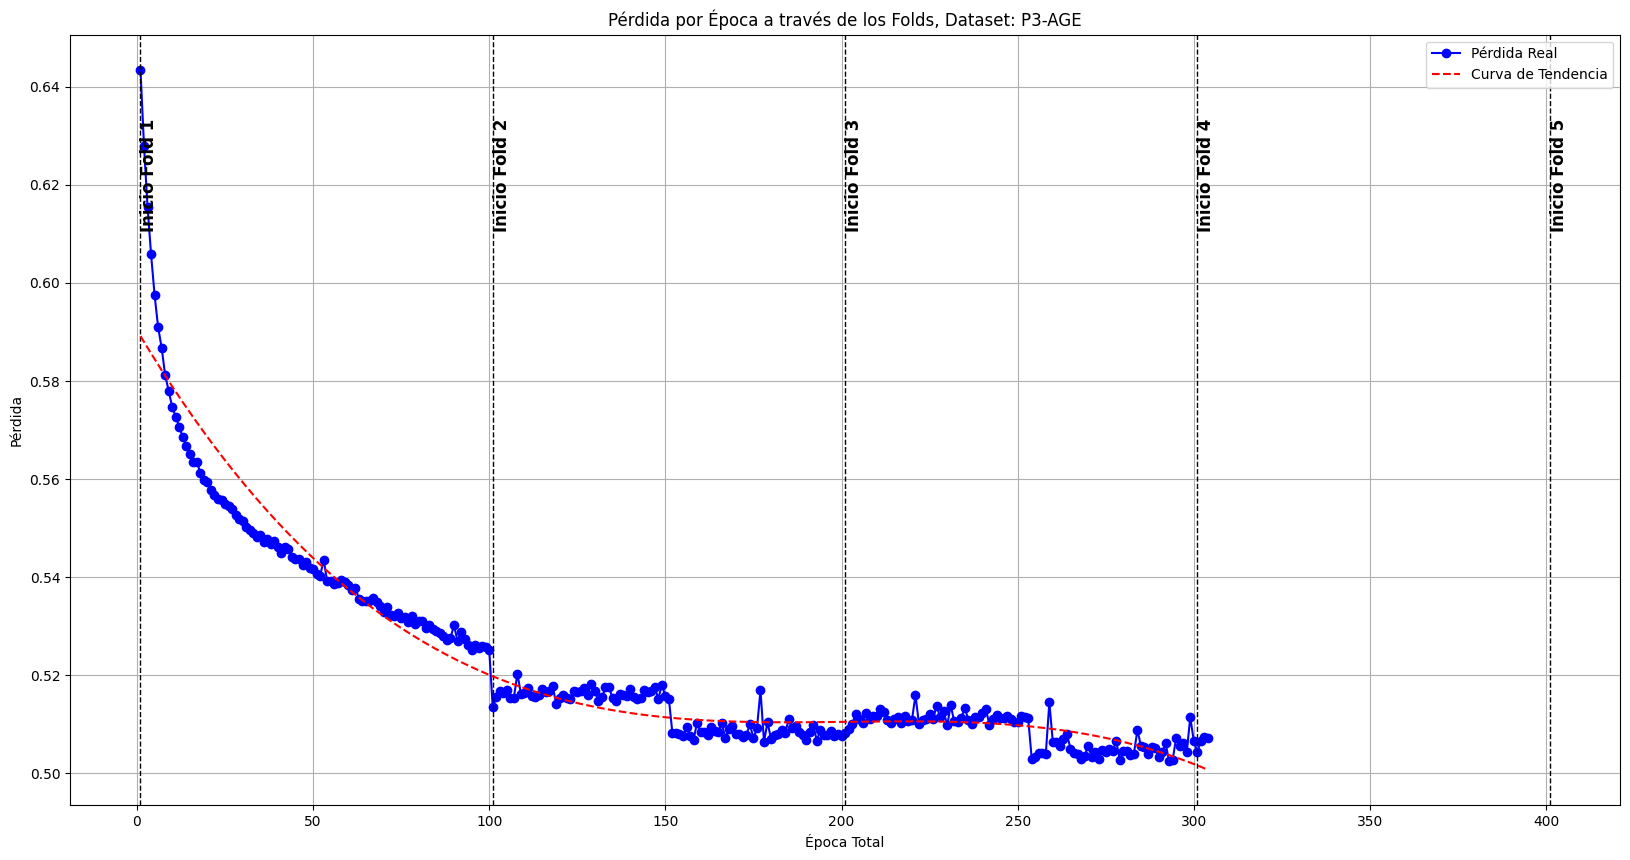

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.724725743037035
Precision (Datos de Train): 0.6401199600133289
Recall (Datos de Train): 0.845776463928549
F1 Score (Datos de Train): 0.7287161979081992
[[12912  7560]
 [ 2452 13447]]


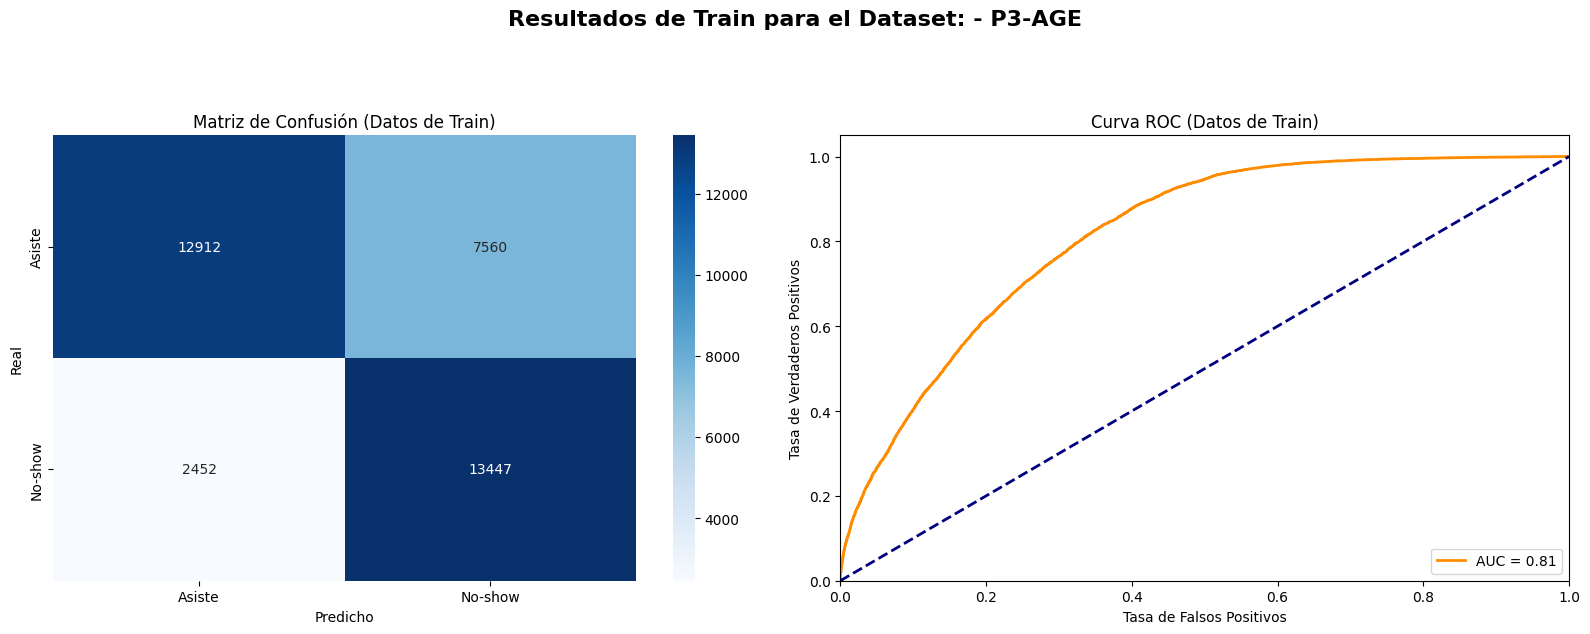

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6866794512464965
Precision (Datos de Test): 0.39444949954504094
Recall (Datos de Test): 0.522289156626506
F1 Score (Datos de Test): 0.4494556765163297
[[3788 1331]
 [ 793  867]]


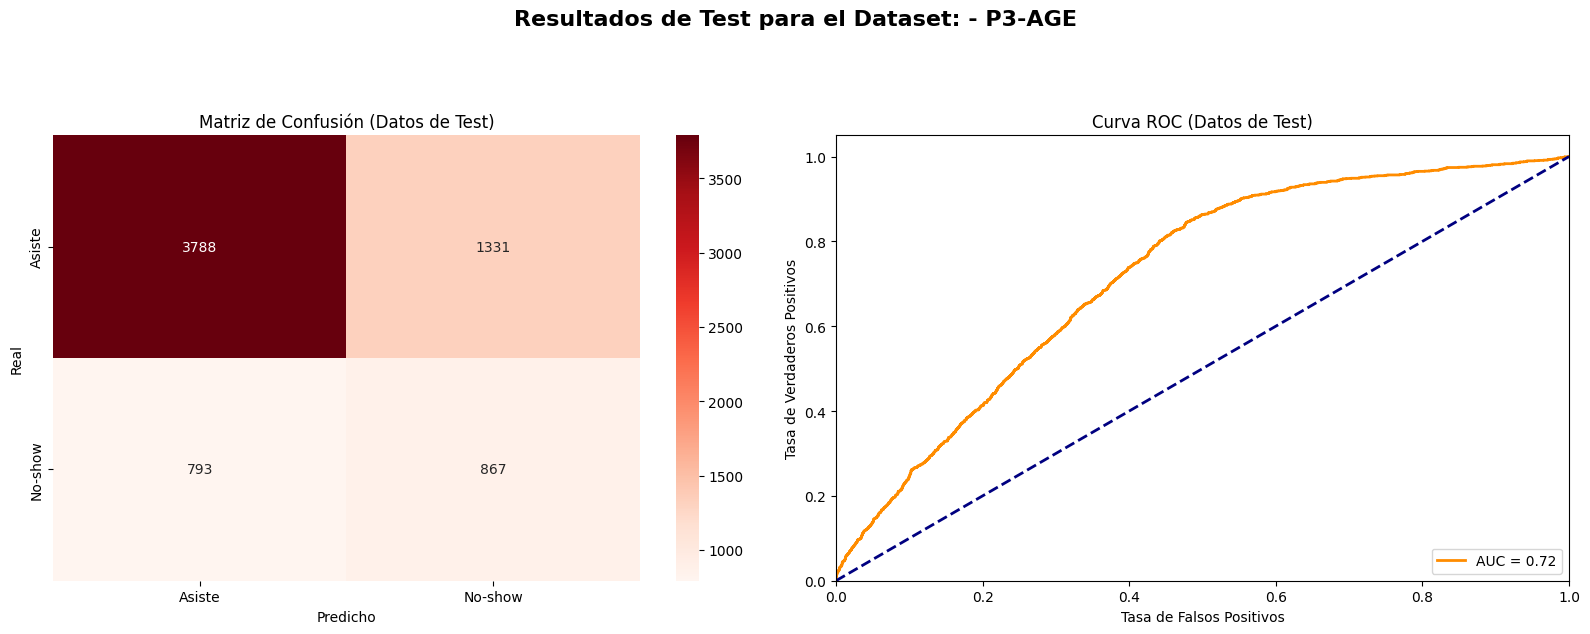


Ejecutando modelo para el dataset: P4-TIME

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6839, Val Loss: 0.6493
Fold 1, Epoch 2, Train Loss: 0.6583, Val Loss: 0.6441
Fold 1, Epoch 3, Train Loss: 0.6528, Val Loss: 0.6421
Fold 1, Epoch 4, Train Loss: 0.6487, Val Loss: 0.6404
Fold 1, Epoch 5, Train Loss: 0.6459, Val Loss: 0.6388
Fold 1, Epoch 6, Train Loss: 0.6451, Val Loss: 0.6379
Fold 1, Epoch 7, Train Loss: 0.6422, Val Loss: 0.6368
Fold 1, Epoch 8, Train Loss: 0.6413, Val Loss: 0.6355
Fold 1, Epoch 9, Train Loss: 0.6396, Val Loss: 0.6344
Fold 1, Epoch 10, Train Loss: 0.6387, Val Loss: 0.6332
Fold 1, Epoch 11, Train Loss: 0.6368, Val Loss: 0.6327
Fold 1, Epoch 12, Train Loss: 0.6366, Val Loss: 0.6321
Fold 1, Epoch 13, Train Loss: 0.6361, Val Loss: 0.6310
Fold 1, Epoch 14, Train Loss: 0.6351, Val Loss: 0.6306
Fold 1, Epoch 15, Train Loss: 0.6324, Val Loss: 0.6291
Fold 1, Epoch 16, Train Loss: 0.6335, Val Loss: 0.6287
Fold 1, Epoch 17, Train Loss: 0.6320, Val Loss: 0.6277
Fold 1, 

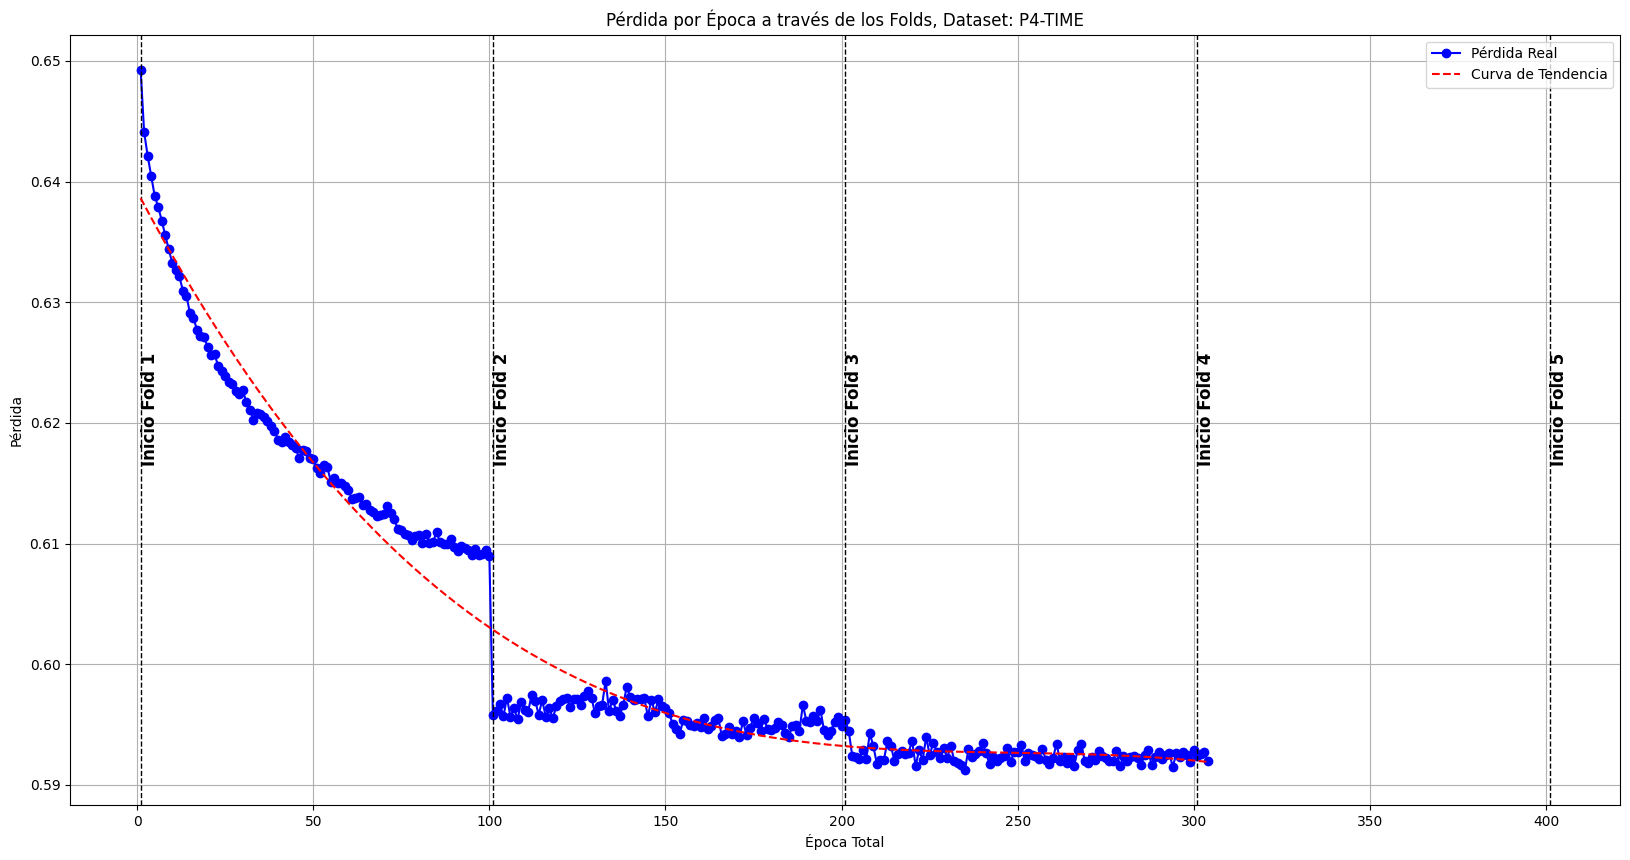

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.6754519271127322
Precision (Datos de Train): 0.6464892322345097
Recall (Datos de Train): 0.4369657737563034
F1 Score (Datos de Train): 0.521468203158344
[[34451  6681]
 [15743 12218]]


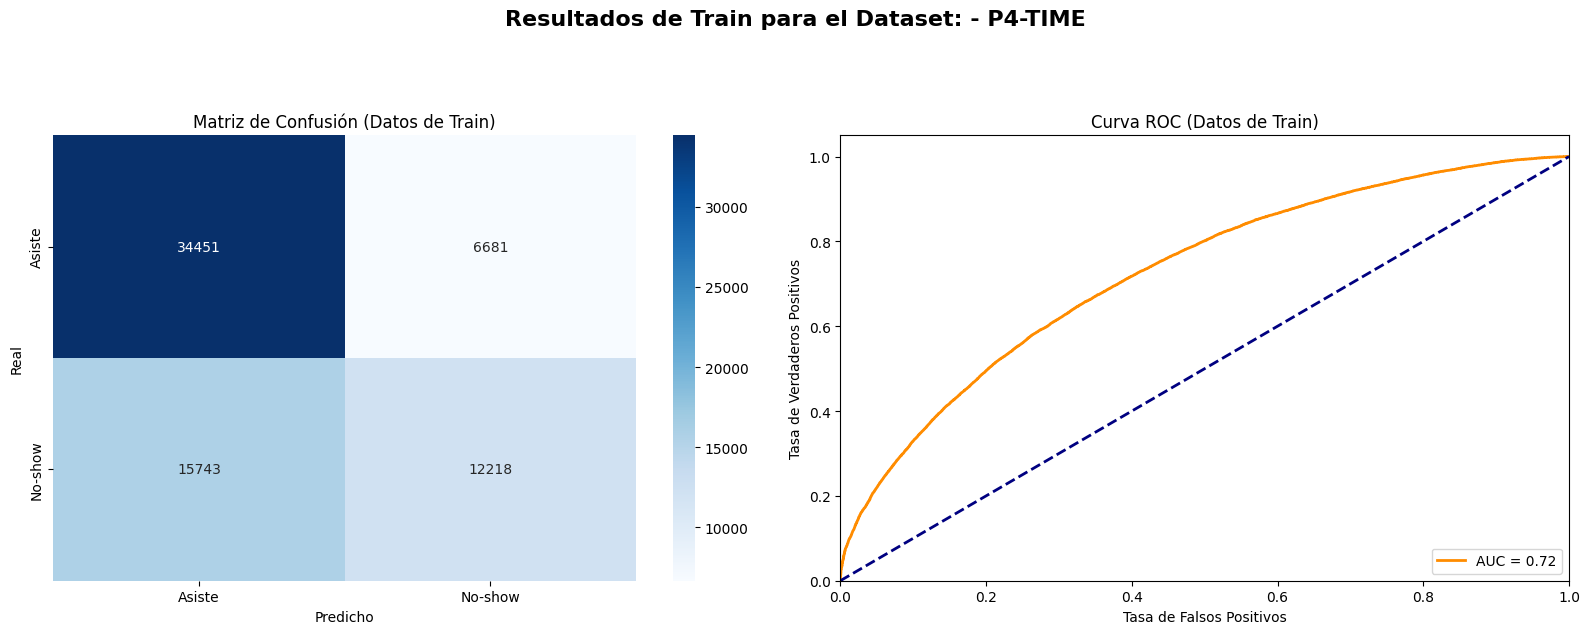

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6995481404240528
Precision (Datos de Test): 0.4228611500701262
Recall (Datos de Test): 0.1470014627011214
F1 Score (Datos de Test): 0.21816208393632416
[[9460  823]
 [3499  603]]


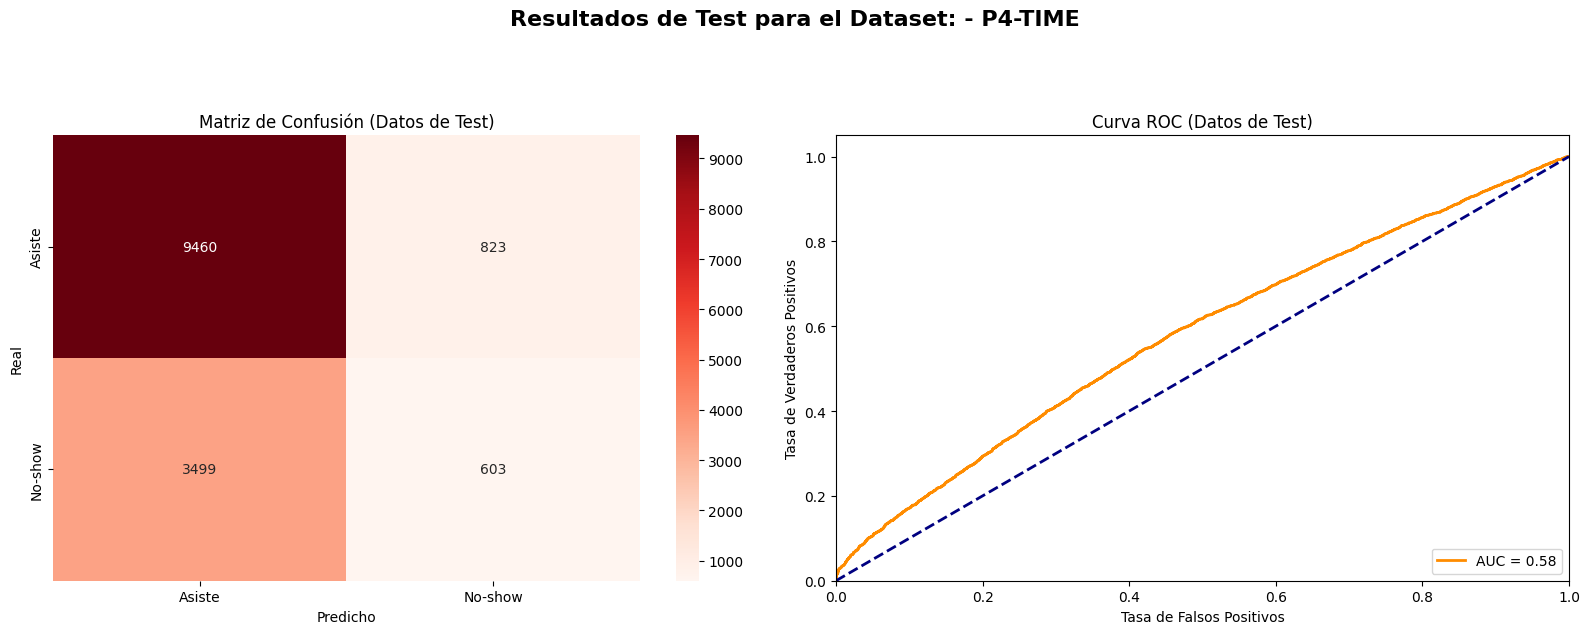


Ejecutando modelo para el dataset: P5-HEALTHCENTRE

Comenzando el fold 1
Fold 1, Epoch 1, Train Loss: 0.6751, Val Loss: 0.6286
Fold 1, Epoch 2, Train Loss: 0.6325, Val Loss: 0.6045
Fold 1, Epoch 3, Train Loss: 0.6134, Val Loss: 0.5882
Fold 1, Epoch 4, Train Loss: 0.6009, Val Loss: 0.5793
Fold 1, Epoch 5, Train Loss: 0.5934, Val Loss: 0.5725
Fold 1, Epoch 6, Train Loss: 0.5885, Val Loss: 0.5677
Fold 1, Epoch 7, Train Loss: 0.5823, Val Loss: 0.5657
Fold 1, Epoch 8, Train Loss: 0.5796, Val Loss: 0.5620
Fold 1, Epoch 9, Train Loss: 0.5764, Val Loss: 0.5604
Fold 1, Epoch 10, Train Loss: 0.5750, Val Loss: 0.5573
Fold 1, Epoch 11, Train Loss: 0.5713, Val Loss: 0.5556
Fold 1, Epoch 12, Train Loss: 0.5691, Val Loss: 0.5550
Fold 1, Epoch 13, Train Loss: 0.5670, Val Loss: 0.5534
Fold 1, Epoch 14, Train Loss: 0.5656, Val Loss: 0.5507
Fold 1, Epoch 15, Train Loss: 0.5648, Val Loss: 0.5492
Fold 1, Epoch 16, Train Loss: 0.5630, Val Loss: 0.5494
Fold 1, Epoch 17, Train Loss: 0.5622, Val Loss: 0.5468


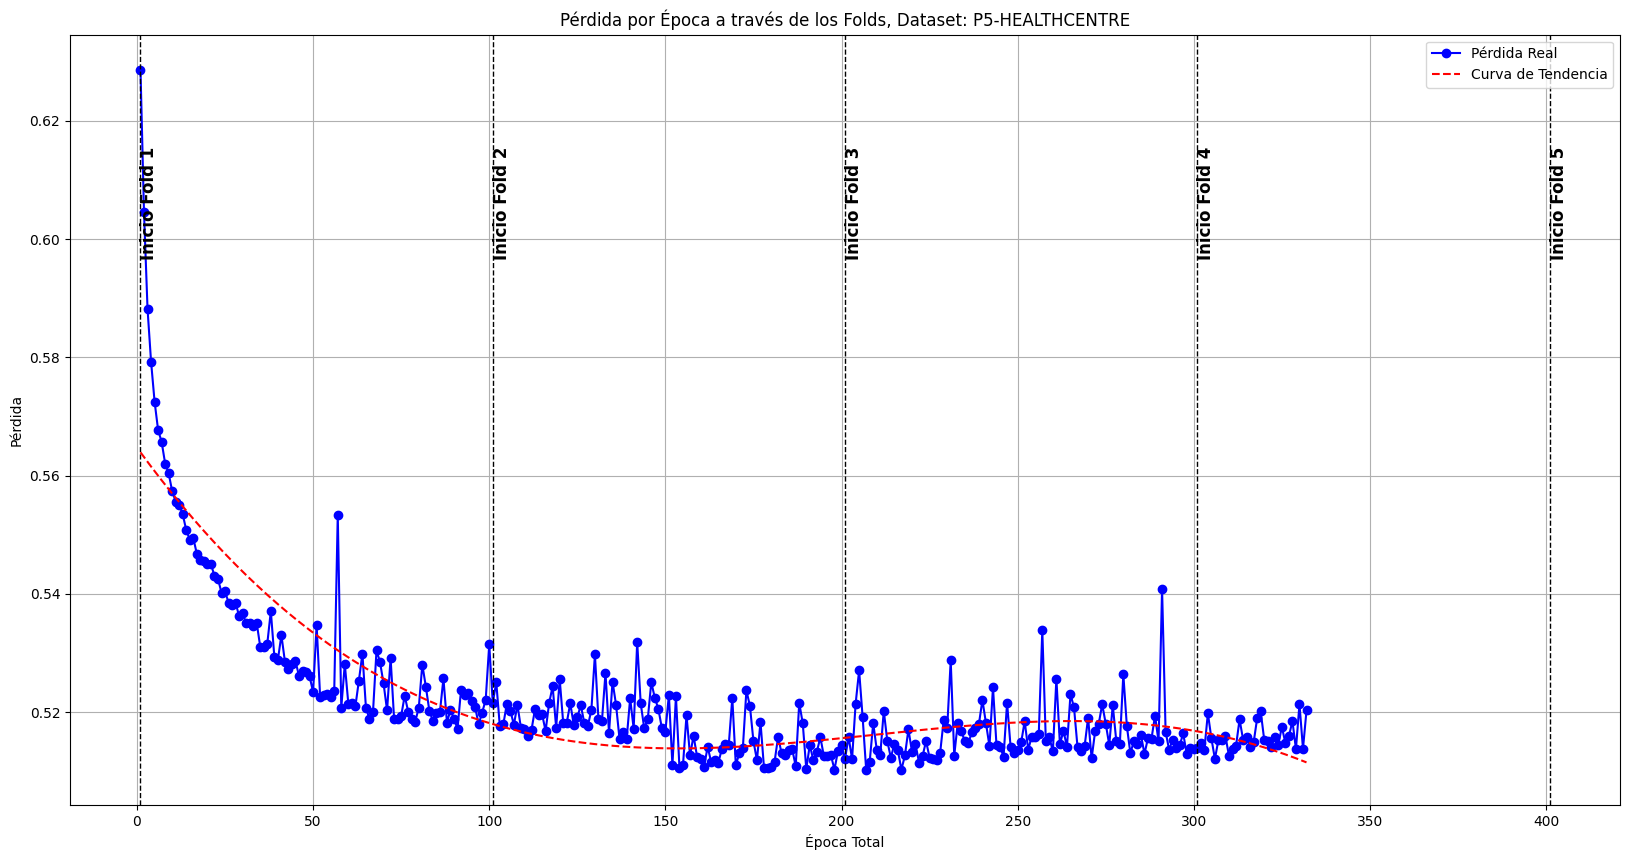

..................................
Resultados datos de entrenamiento:
Accuracy (Datos de Train): 0.727733535274575
Precision (Datos de Train): 0.6549586776859504
Recall (Datos de Train): 0.8188288313044434
F1 Score (Datos de Train): 0.7277834088438946
[[29783 15698]
 [ 6593 29798]]


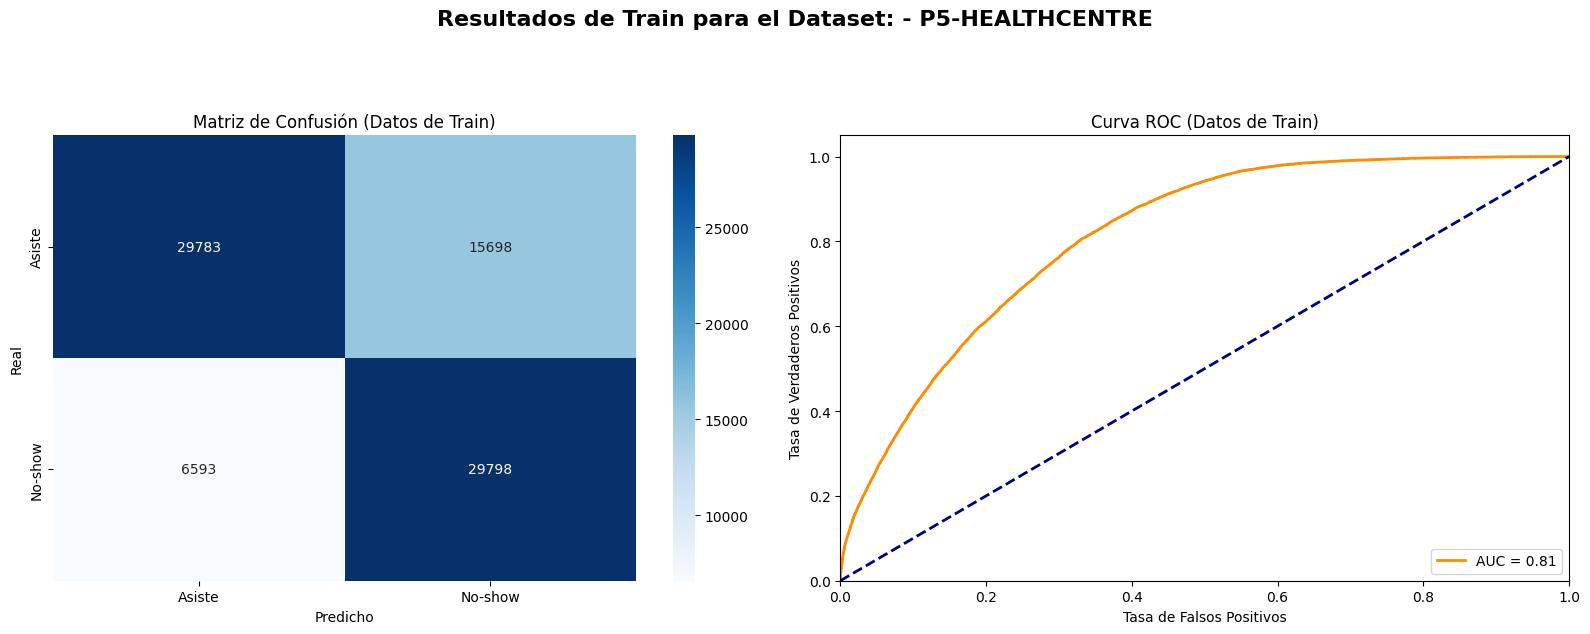

.........................
Resultados datos de test:
Accuracy (Datos de Test): 0.6807765085149625
Precision (Datos de Test): 0.34009269988412516
Recall (Datos de Test): 0.6074508451190066
F1 Score (Datos de Test): 0.4360529899715241
[[7953 3417]
 [1138 1761]]


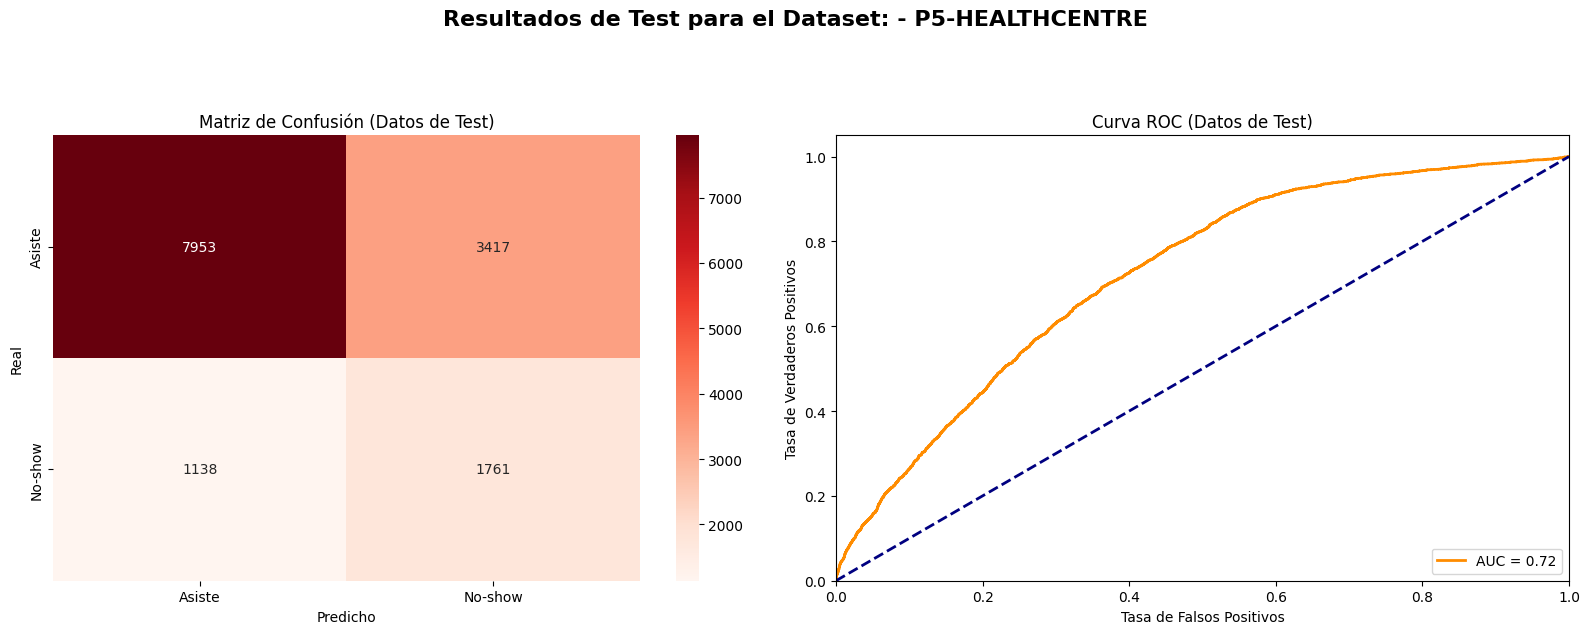

In [22]:
def load_data(file_path):
    return joblib.load(file_path)

# Listado de archivos
X_test_files = [
    "X_test_P1-ALL-ADASYN.pkl", "X_test_P1-ALL.pkl", "X_test_P2-NOCONDITIONS.pkl", 
    "X_test_P3-AGE.pkl", "X_test_P4-TIME.pkl", "X_test_P5-HEALTHCENTRE.pkl"
]

X_train_files = [
    "X_train_P1-ALL-ADASYN.pkl", "X_train_P1-ALL.pkl", "X_train_P2-NOCONDITIONS.pkl", 
    "X_train_P3-AGE.pkl", "X_train_P4-TIME.pkl", "X_train_P5-HEALTHCENTRE.pkl"
]

y_test_files = [
    "y_test_P1-ALL-ADASYN.pkl", "y_test_P1-ALL.pkl", "y_test_P2-NOCONDITIONS.pkl", 
    "y_test_P3-AGE.pkl", "y_test_P4-TIME.pkl", "y_test_P5-HEALTHCENTRE.pkl"
]

y_train_files = [
    "y_train_P1-ALL-ADASYN.pkl", "y_train_P1-ALL.pkl", "y_train_P2-NOCONDITIONS.pkl", 
    "y_train_P3-AGE.pkl", "y_train_P4-TIME.pkl", "y_train_P5-HEALTHCENTRE.pkl"
]

file_names = [
    "P1-ALL-ADASYN", "P1-ALL", "P2-NOCONDITIONS", 
    "P3-AGE", "P4-TIME", "P5-HEALTHCENTRE"
]

# Se cargan los archivos en un diccionario
data = {}
for file_list in [X_test_files, X_train_files, y_test_files, y_train_files]:
    for file_name in file_list:
        data[file_name] = load_data(file_name)

# Se crea bucle para analizar los datos con el modelo de PyTorch
for idx, (X_train_file, y_train_file, X_test_file, y_test_file) in enumerate(zip(X_train_files, y_train_files, X_test_files, y_test_files)):
    try:
        if X_train_file in data and y_train_file in data and X_test_file in data and y_test_file in data:
            X_train = data[X_train_file]
            y_train = data[y_train_file]
            X_test = data[X_test_file]
            y_test = data[y_test_file]

            dataset_name = file_names[idx]
            titulo = f"\n{'='*40}\nEjecutando modelo para el dataset: {dataset_name}\n{'='*40}\n"
            print(titulo)

            execute_model_pytorch(X_train, y_train, X_test, y_test, device='cuda', dataset_name=dataset_name)
        else:
            print(f"Archivos correspondientes no encontrados para {X_train_file}. Omitiendo este archivo.")
    except KeyError as e:
        print(f"Error: {e} - La clave no existe en el diccionario 'data'. Omitiendo este archivo.")
